ASSIGNMENT-2

 Implementing an image classification model using a Convolutional Neural
Network (CNN) in PyTorch using image classification dataset Fashion-MNIST

Epoch 1/10, Loss: 0.6983986611061908
Epoch 2/10, Loss: 0.3924739696878068
Epoch 3/10, Loss: 0.3299582511820692
Epoch 4/10, Loss: 0.30336321145296097
Epoch 5/10, Loss: 0.2825816216620993
Epoch 6/10, Loss: 0.2668028586405389
Epoch 7/10, Loss: 0.2546561450717297
Epoch 8/10, Loss: 0.24443395530923884
Epoch 9/10, Loss: 0.23049233029497432
Epoch 10/10, Loss: 0.22043820581537613
Validation Accuracy: 90.275%
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.85      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.81      0.86      0.83      1000
       Dress       0.90      0.90      0.90      1000
        Coat       0.86      0.80      0.83      1000
      Sandal       0.96      0.98      0.97      1000
       Shirt       0.71      0.70      0.71      1000
     Sneaker       0.97      0.91      0.94      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.93      0.97      0.95      1000



<ipython-input-17-b182285f5551>:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fashion_mnist_cnn_model.pth'))


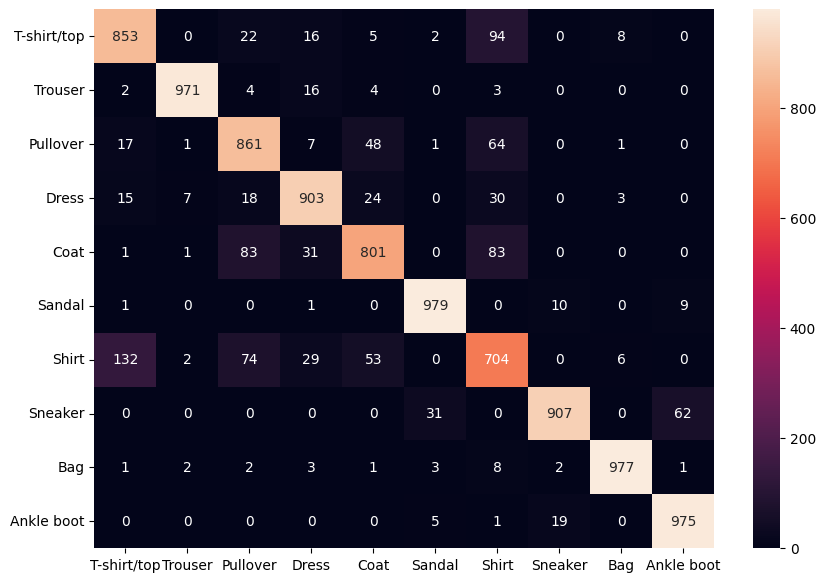

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import FashionMNIST

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split the training dataset
X_train, X_validation, y_train, y_validation = train_test_split(train_dataset.data.numpy(),
                                                              train_dataset.targets.numpy(),
                                                              test_size=0.2, random_state=2020)

X_train = torch.tensor(X_train, dtype=torch.float32) / 255
X_validation = torch.tensor(X_validation, dtype=torch.float32) / 255
y_train = torch.tensor(y_train, dtype=torch.long)
y_validation = torch.tensor(y_validation, dtype=torch.long)

X_test = test_dataset.data.numpy().reshape(-1, 1, 28, 28) / 255
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(test_dataset.targets.numpy(), dtype=torch.long)

# Create data loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=512, shuffle=True)
validation_loader = DataLoader(TensorDataset(X_validation, y_validation), batch_size=512, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=512, shuffle=False)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 14 * 14)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = CNNModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

# Evaluate the model on the validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total}%')

# Test the model
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)

# Classification Report
cr = classification_report(y_true, y_pred, target_names=train_dataset.classes)
print(cr)

# Save the model
torch.save(model.state_dict(), 'fashion_mnist_cnn_model.pth')

# Load the model (for inference)
model = CNNModel().to(device)
model.load_state_dict(torch.load('fashion_mnist_cnn_model.pth'))
model.eval()

# Make a prediction on a single sample
sample = X_test[0].unsqueeze(0).to(device)
output = model(sample)
_, predicted_class = torch.max(output, 1)

print(f'Predicted Class: {train_dataset.classes[predicted_class]}')
print(f'Actual Class: {train_dataset.classes[y_test[0]]}')


Used Keras to build Neural Network

((48000, 28, 28, 1), (48000,), (12000, 28, 28, 1), (12000,))

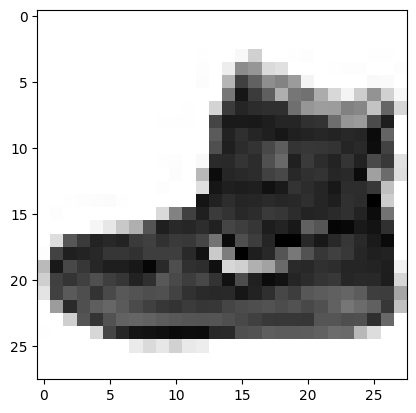

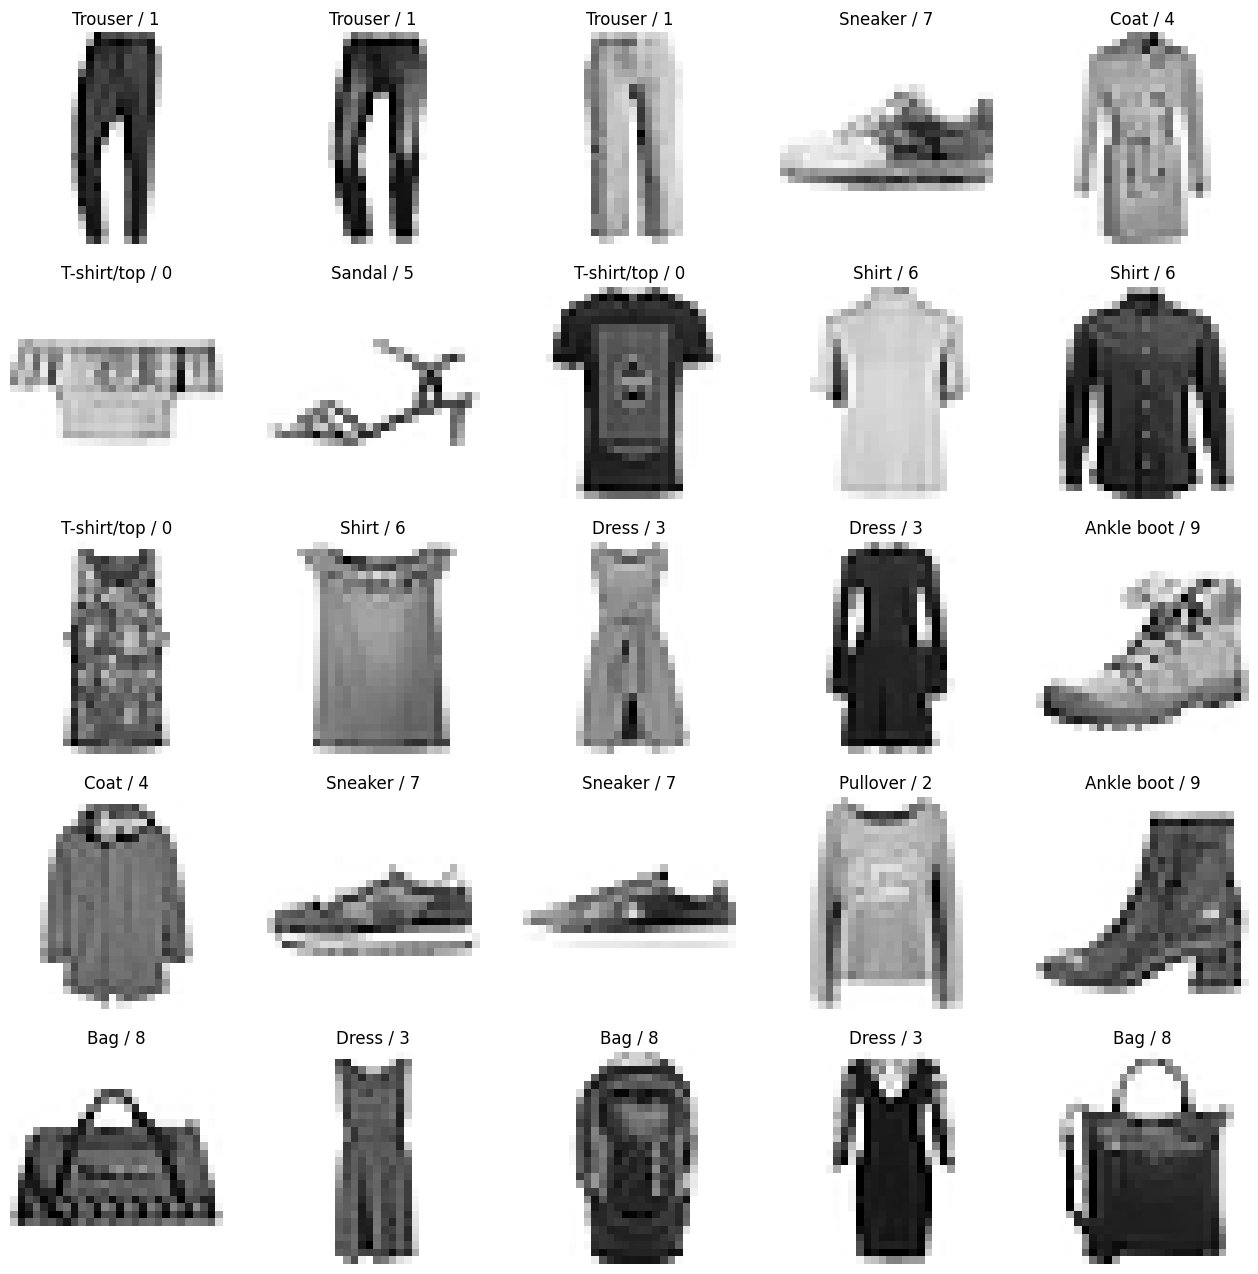

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # load dataset from  keras
X_train.shape, y_train.shape, "******", X_test.shape, y_test.shape
X_train[0]
y_train[0]
class_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
plt.imshow(X_train[0], cmap='Greys')
plt.figure(figsize=(16,16))

j=1
for i in np.random.randint(0, 1000, 25):
  plt.subplot(5,5,j); j+=1
  plt.imshow(X_train[i], cmap="Greys")
  plt.axis('off') # off the axis
  plt.title('{} / {}'.format(class_labels[y_train[i]], y_train[i]))

X_train.shape
X_train.ndim
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
X_train.ndim
X_train = X_train/255
X_test = X_test/255
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size= 0.2, random_state=2020)

X_train.shape,  y_train.shape, X_validation.shape, y_validation.shape

In [15]:
cnn_model = keras.models.Sequential([
                         keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), padding='valid',activation= 'relu', input_shape=[28,28,1]),
                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                         keras.layers.Flatten(),
                         keras.layers.Dense(units=128, activation='relu'),
                         keras.layers.Dense(units=10, activation='softmax')
])

cnn_model.summary()
cnn_model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
# train cnn model
cnn_model.fit(X_train, y_train, epochs=10, batch_size=512, verbose=1, validation_data=(X_validation, y_validation))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 5408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │         692,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,962 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 282ms/step - accuracy: 0.7005 - loss: 0.9145 - val_accuracy: 0.8412 - val_loss: 0.4488
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 276ms/step - accuracy: 0.8675 - loss: 0.3829 - val_accuracy: 0.8800 - val_loss: 0.3486
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 269ms/step - accuracy: 0.8880 - loss: 0.3195 - val_accuracy: 0.8877 - val_loss: 0.3289
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - accuracy: 0.8988 - loss: 0.2942 - val_accuracy: 0.8930 - val_loss: 0.3074
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 291ms/step - accuracy: 0.9022 - loss: 0.2796 - val_accuracy: 0.8960 - val_loss: 0.3004
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.9089 - loss: 0.2563 - val_accuracy: 0.8978 - val_loss: 0.2900
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.9136 - loss: 0.2437 - val_accuracy: 0.8966 - val_loss: 0.2927
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 258ms/step - accuracy: 0.9151 - loss: 0.2356 - val_accu

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9066 - loss: 0.2718
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.88      0.86      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.82      0.86      0.84      1000
       Dress       0.89      0.92      0.90      1000
        Coat       0.86      0.85      0.85      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.77      0.68      0.72      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



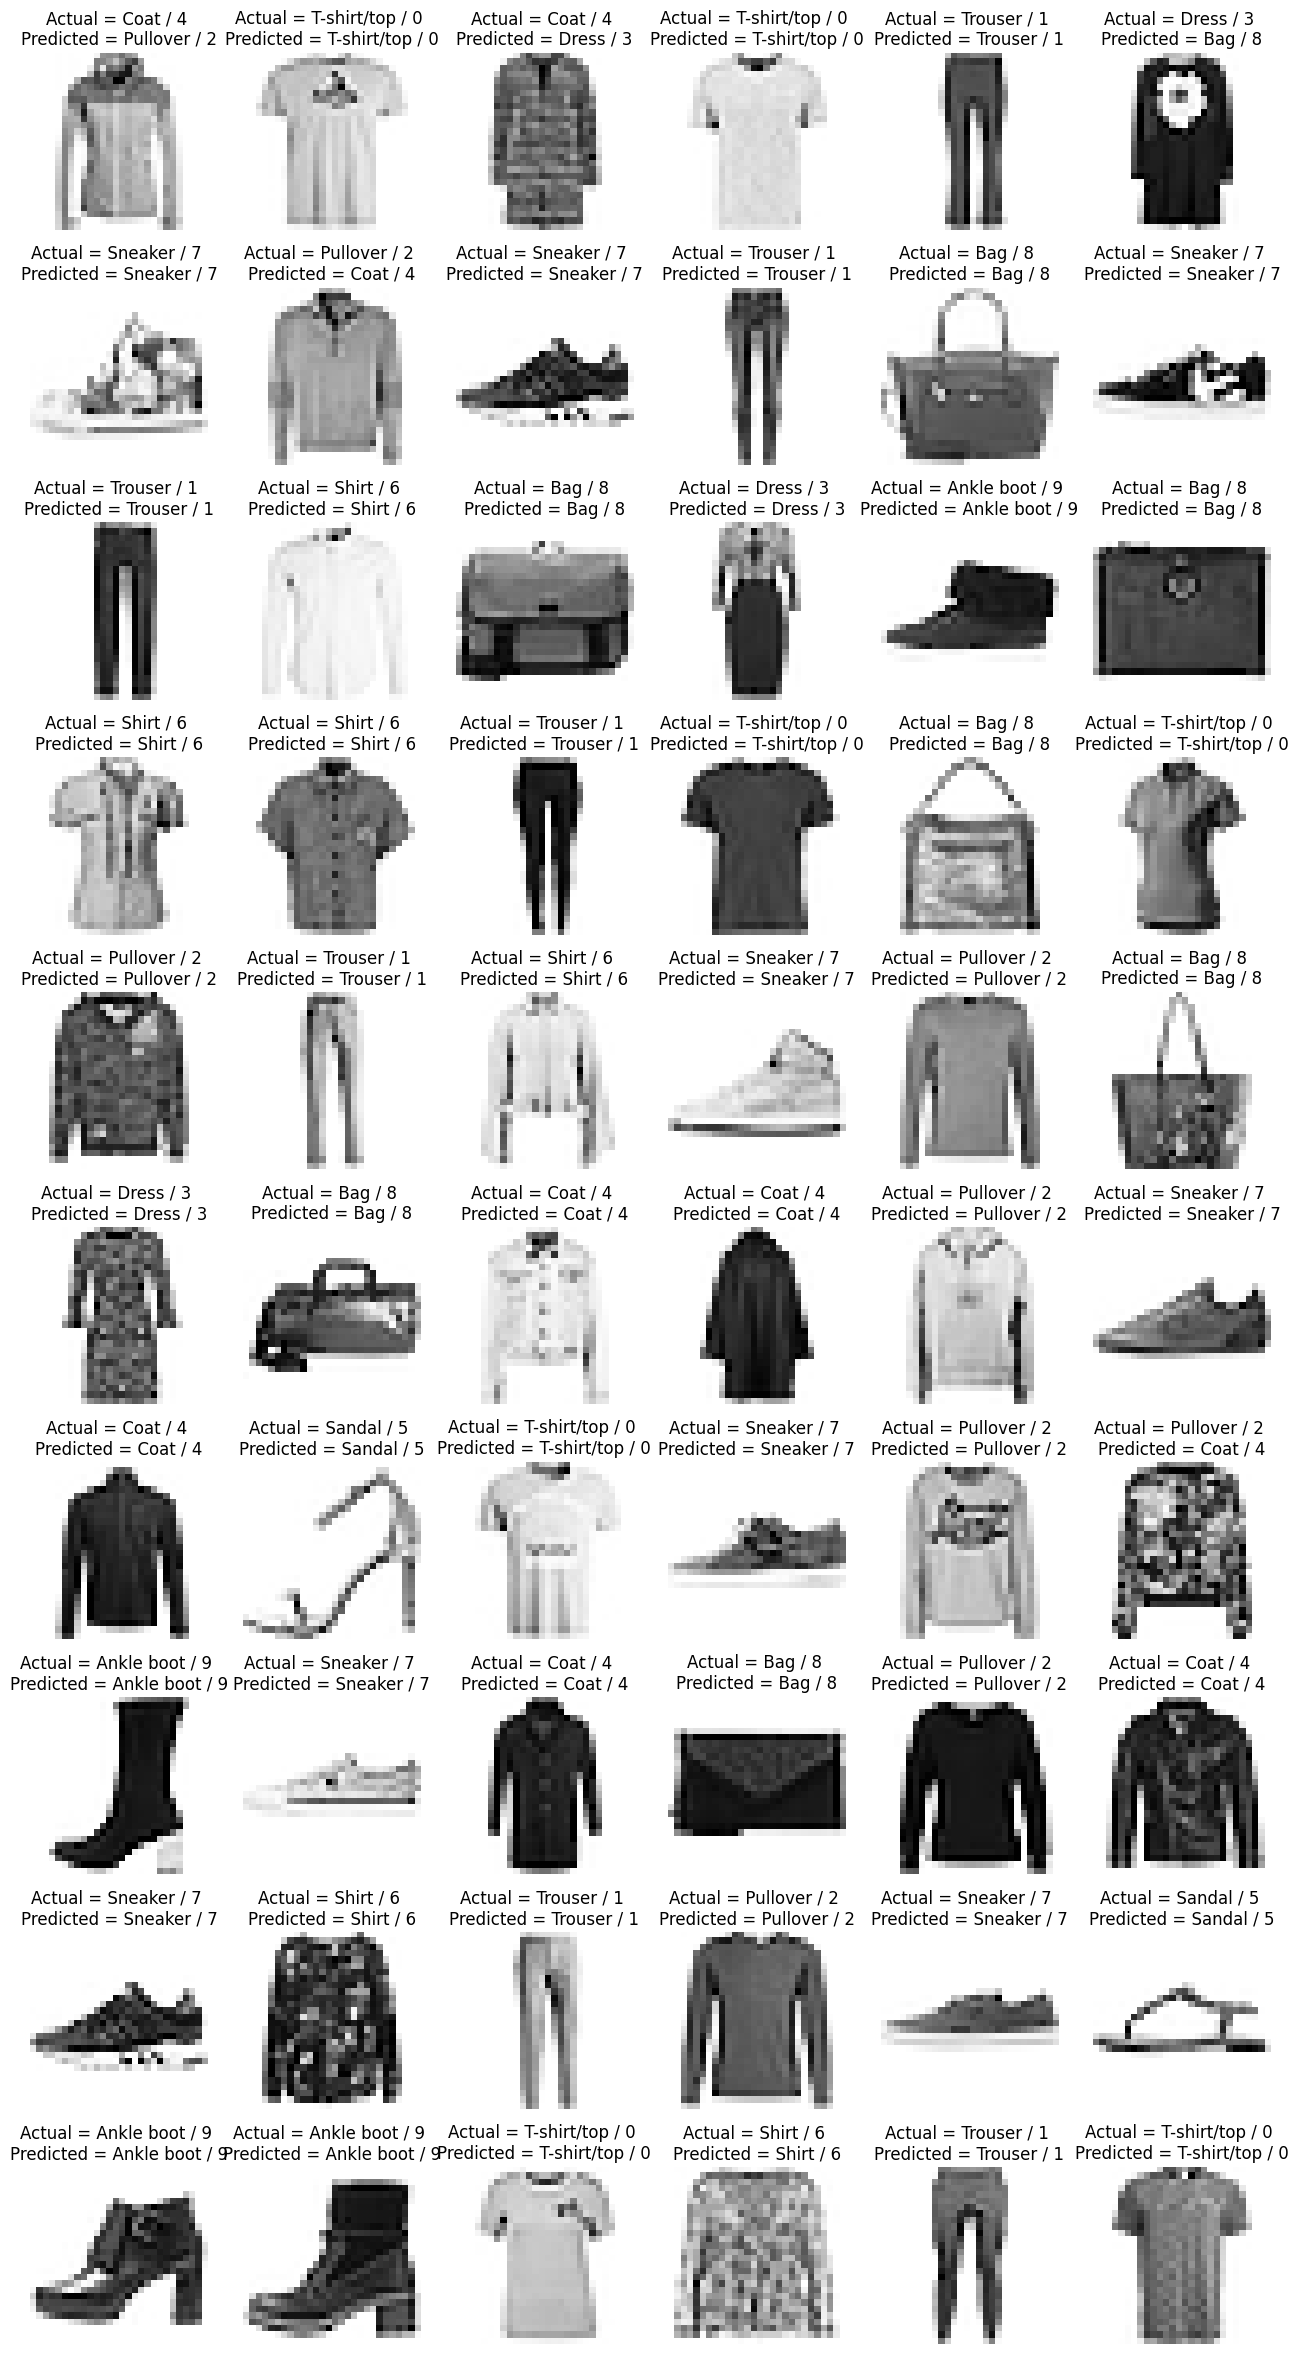

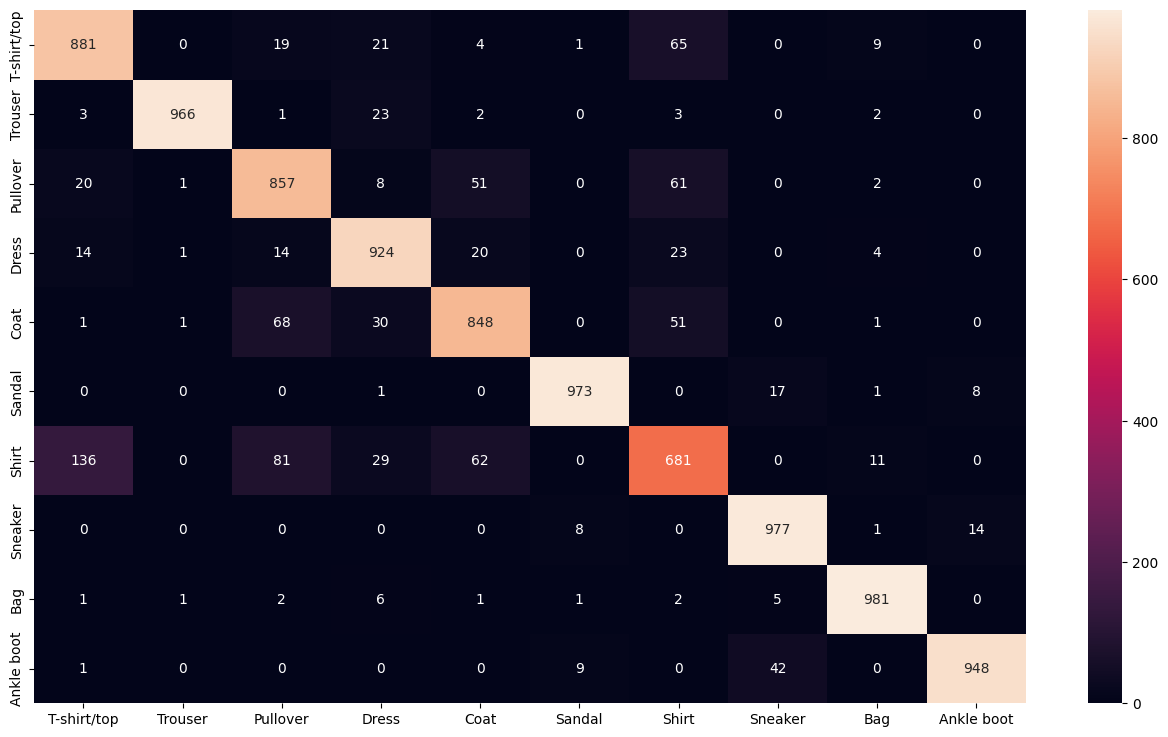

In [3]:
# Test the Model
y_pred = cnn_model.predict(X_test)
y_pred.round(2)
y_test
cnn_model.evaluate(X_test, y_test)

plt.figure(figsize=(16,30))

j=1
for i in np.random.randint(0, 1000,60):
  plt.subplot(10,6, j); j+=1
  plt.imshow(X_test[i].reshape(28,28), cmap = 'Greys')
  plt.title('Actual = {} / {} \nPredicted = {} / {}'.format(class_labels[y_test[i]], y_test[i], class_labels[np.argmax(y_pred[i])],np.argmax(y_pred[i])))
  plt.axis('off')

# Confusion Matrix

from sklearn.metrics import confusion_matrix

plt.figure(figsize=(16,9))
y_pred_labels = [ np.argmax(label) for label in y_pred ]
cm = confusion_matrix(y_test, y_pred_labels)

# show cm
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_labels, yticklabels=class_labels)

from sklearn.metrics import classification_report
cr= classification_report(y_test, y_pred_labels, target_names=class_labels)
print(cr)

In [16]:
# Save Model
cnn_model.save('fashion_mnist_cnn_model.h5')
fashion_mnist_cnn_model = keras.models.load_model('fashion_mnist_cnn_model.h5')
Y_pred_sample = fashion_mnist_cnn_model.predict(np.expand_dims(X_test[0], axis=0)).round(2)
Y_pred_sample
np.argmax(Y_pred_sample[0])
y_test[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


9